#Cyberthreat

#Import libariries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

#import dataset

In [2]:
data = pd.read_csv('/content/sample_data/cyberthreat.csv')
data

,Protocol,Flag,Packet,Sender ID,Receiver ID,Source IP Address,Destination IP Address,Source Port,Destination Port,No of Files affected,Packet Size
0,TCP,SYN,HTTP,123456,987654,192.168.0.1,10.0.0.5,12345,80,230.0,1024
1,UDP,ACK,DNS,987654,123456,10.0.0.2,192.168.0.1,53,12345,12.0,512
2,TCP,SYN,SSH,789012,345678,192.168.1.10,10.0.0.8,22,12345,17.0,256
3,UDP,ACK,NTP,345678,789012,10.0.0.5,192.168.1.10,123,12345,23.0,128
4,TCP,RST,FTP,234567,456789,192.168.0.5,10.0.0.10,20,12345,19.0,2048
...,...,...,...,...,...,...,...,...,...,...,...
745,TCP,SYN,FTP,567890,890123,192.168.1.5,10.0.0.10,21,12345,9.0,512
746,UDP,ACK,DNS,901234,678901,10.0.0.15,192.168.0.2,12345,53,8.0,256
747,TCP,SYN,SSH,234567,456789,192.168.0.5,10.0.0.10,22,12345,3.0,256
748,UDP,ACK,NTP,456789,234567,10.0.0.8,192.168.0.5,123,12345,4.0,128


#data pre-processing

In [3]:
data.dropna(inplace=True)

In [4]:
# Find the number of missing values in each column
missing_values_count = data.isnull().sum()
missing_values_count

# For numerical columns, replace missing values with the mean
numeric_columns = data.select_dtypes(include=np.number).columns
for i in numeric_columns:
    data[i] = data[i].fillna(data[i].mean())

# For categorical columns, replace missing values with the mode
categorical_columns = data.select_dtypes(include='object').columns
for i in categorical_columns:
    data[i] = data[i].fillna(data[i].mode()[0])

#data visualization

<ipython-input-5-20961fed0bc6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


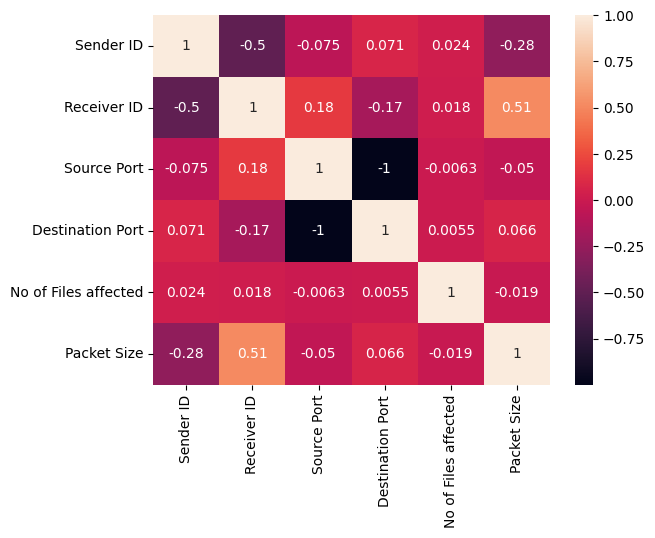

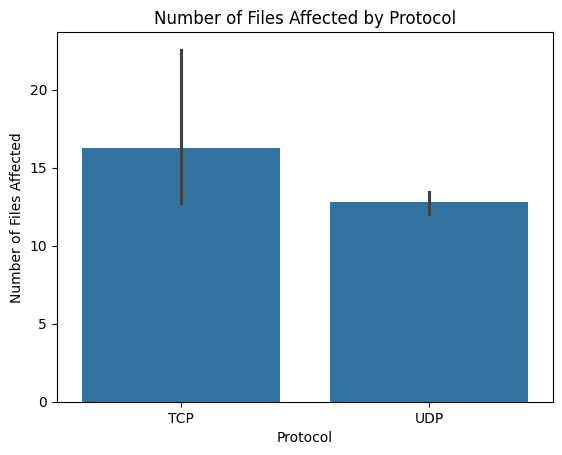

In [5]:
# Heat map for correlation
corr = data.corr()
sns.heatmap(corr, annot=True)
plt.show()

# Bar plot of protocol vs. number of files affected
sns.barplot(x='Protocol', y='No of Files affected', data=data)
plt.title('Number of Files Affected by Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Files Affected')
plt.show()

#Box-Plot analysis for Outlier Detection

0     230.0
8    1024.0
Name: No of Files affected, dtype: float64
Five Point Summary for No of Files Affected :  {'Min': 1.0, 'Q1': 7.0, 'Median': 12.0, 'Q3': 19.0, 'Max': 1024.0}


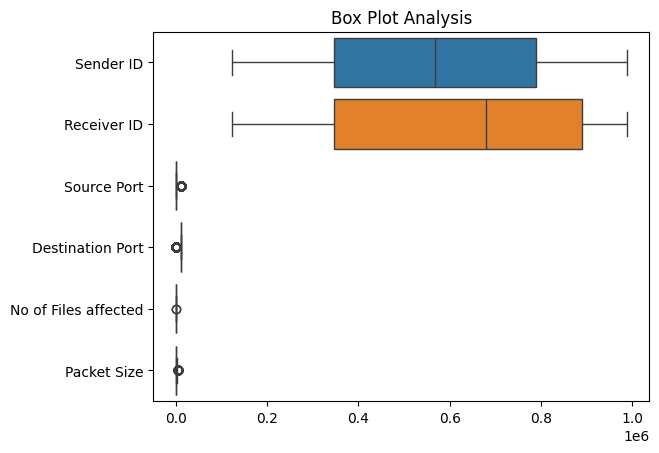

In [8]:
number_of_file_affected = data['No of Files affected']
mean = np.mean(number_of_file_affected)
median = np.median(number_of_file_affected)
quartile = np.percentile(number_of_file_affected, [25,50,75])
min_val = np.min(number_of_file_affected)
max_val = np.max(number_of_file_affected)

Q1 = quartile[0]
Q3 = quartile[2]

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = number_of_file_affected[(number_of_file_affected < lower_bound)|(number_of_file_affected > upper_bound)]
print(outliers)

five_point_summary = {
    'Min': min_val,
    'Q1': quartile[0],
    'Median': median,
    'Q3': quartile[2],
    'Max': max_val
}
print("Five Point Summary for No of Files Affected : ",five_point_summary)
sns.boxplot(data=data, orient='h')
plt.title("Box Plot Analysis")
plt.show()

#ZSCORE to find outlier

In [9]:
# Calculate Z-scores for the 'number of files affected' column
number_of_file_affected = data['No of Files affected']
z_scores = stats.zscore(number_of_file_affected)
threshold = 3
# Find outliers
outliers = number_of_file_affected[abs(z_scores) > threshold]
print("Outliers found using Z-score method:")
print(outliers)


Outliers found using Z-score method:
0     230.0
8    1024.0
Name: No of Files affected, dtype: float64


In [10]:
# without scipy module

mean = number_of_file_affected.mean()
std_dev = number_of_file_affected.std()
data['Z_score'] = (number_of_file_affected - mean) / std_dev
threshold = 3
outliers = data[abs(data['Z_score']) > threshold]

print("Outliers found using Z-score method:")
print(outliers)

Outliers found using Z-score method:
  Protocol Flag Packet  Sender ID  Receiver ID Source IP Address  \
0      TCP  SYN   HTTP     123456       987654       192.168.0.1   
8      TCP  SYN   SMTP     901234       678901       192.168.0.2   

  Destination IP Address  Source Port  Destination Port  No of Files affected  \
0               10.0.0.5        12345                80                 230.0   
8              10.0.0.15           25             12345                1024.0   

   Packet Size    Z_score  
0         1024   5.606044  
8          512  26.265162  


#2 Clustering Algorithms

In [11]:
# Select relevant features for clustering
X = data[['No of Files affected', 'Packet Size']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define K-means clustering model
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
kmeans_labels = kmeans.labels_
data['KMeans_Cluster'] = kmeans_labels
kmeans_cluster_counts = data['KMeans_Cluster'].value_counts()
kmeans_anomalies = data[data['KMeans_Cluster'].isin(kmeans_cluster_counts[kmeans_cluster_counts < 5].index)]

print("\nAnomalies detected by K-means:")
print(kmeans_anomalies)

# Define DBSCAN clustering model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_scaled)
dbscan_labels = dbscan.labels_
data['DBSCAN_Cluster'] = dbscan_labels
db_outliers = data[data['DBSCAN_Cluster'] == -1]

print("Anomalies detected by DBSCAN:")
print(db_outliers)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Anomalies detected by K-means:
  Protocol Flag Packet  Sender ID  Receiver ID Source IP Address  \
8      TCP  SYN   SMTP     901234       678901       192.168.0.2   

  Destination IP Address  Source Port  Destination Port  No of Files affected  \
8              10.0.0.15           25             12345                1024.0   

   Packet Size    Z_score  KMeans_Cluster  
8          512  26.265162               2  
Anomalies detected by DBSCAN:
  Protocol Flag Packet  Sender ID  Receiver ID Source IP Address  \
0      TCP  SYN   HTTP     123456       987654       192.168.0.1   
8      TCP  SYN   SMTP     901234       678901       192.168.0.2   

  Destination IP Address  Source Port  Destination Port  No of Files affected  \
0               10.0.0.5        12345                80                 230.0   
8              10.0.0.15           25             12345                1024.0   

   Packet Size    Z_score  KMeans_Cluster  DBSCAN_Cluster  
0         1024   5.606044               1

#Grocery dataset

#Import libararies

In [12]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

#import dataset

In [13]:
data = pd.read_csv('/content/sample_data/Groceries_dataset.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#data preprocessing and list of transactions

In [ ]:
#Convert 'Date' column to datetime format
Date = pd.to_datetime(data['Date'])

data.drop_duplicates(inplace=True)

# Create a list of transactions
transactions_list = data.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).values.tolist()
transactions_list

#Apriori

In [15]:
# Convert the DataFrame to a transaction format suitable for Apriori
basket = (data.groupby(['Member_number', 'Date'])['itemDescription']
          .apply(list).tolist())

encoder = TransactionEncoder()
basket_encoded = encoder.fit_transform(basket)

basket_data = pd.DataFrame(basket_encoded, columns=encoder.columns_)

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket_data, min_support=0.01, use_colnames=True)
print("\nFrequent Itemsets:")
print(frequent_itemsets)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print("\nAssociation Rules:")
print(rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Frequent Itemsets:
     support                        itemsets
0   0.021386                      (UHT-milk)
1   0.033950                          (beef)
2   0.021787                       (berries)
3   0.016574                     (beverages)
4   0.045312                  (bottled beer)
..       ...                             ...
64  0.010559  (other vegetables, rolls/buns)
65  0.014837  (whole milk, other vegetables)
66  0.013968        (whole milk, rolls/buns)
67  0.011629              (whole milk, soda)
68  0.011161            (whole milk, yogurt)

[69 rows x 2 columns]

Association Rules:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []
